In [ ]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib notebook
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend
from samplers import *

In [ ]:
sm_refpoints = ps.StanModel(file="nn_refpoints_GPprior.stan")

In [ ]:
Y = np.genfromtxt('GeodesicDistance/sphere.txt', delimiter=',')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Y[:,0], ys=Y[:,1], zs=Y[:,2], zdir='z', s=3, c=None, depthshade=True, color="blue")
ax.scatter(xs=Y[27,0], ys=Y[27,1], zs=Y[27,2], zdir='z', s=25, c=None, depthshade=True, color="red")
ax.scatter(xs=Y[909,0], ys=Y[909,1], zs=Y[909,2], zdir='z', s=25, c=None, depthshade=True, color="red")
ax.scatter(xs=Y[434,0], ys=Y[434,1], zs=Y[434,2], zdir='z', s=25, c=None, depthshade=True, color="green")
ax.scatter(xs=Y[132,0], ys=Y[132,1], zs=Y[132,2], zdir='z', s=25, c=None, depthshade=True, color="green")
ax.scatter(xs=Y[114,0], ys=Y[114,1], zs=Y[114,2], zdir='z', s=50, c=None, depthshade=True, color="yellow")
plt.show()

<IPython.core.display.Javascript object>

In [37]:
lm_1 = [27,909]
lm_2 = [434,132]
c = [114]
ref_points = []
ref_points.append(lm_1)
ref_points.append(lm_2)
ref_points.append(c)
ref_points = sum(ref_points, [])
n_ref = len(ref_points)

In [44]:
n_ref = len(ref_points)
Nobs = np.shape(X)[0]
train = np.setdiff1d(np.arange(Nobs), ref_points)
y_ref = Y[ref_points]
X_ref = np.zeros((n_ref,2))
X_ref[0] = [-3,0]
X_ref[1] = [3,0]
X_ref[2] = [0,3]
X_ref[3] = [0,-3]
X_ref[4] = [0,0]

In [48]:
Y_new = np.zeros(np.shape(Y))
for i in range(n_ref) :
    Y_new[i] = Y[ref_points[i]]
Y_new[n_ref::] = Y[np.setdiff1d(np.arange(Nobs), ref_points)]

In [55]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=2, 
                      out_dim=3, 
                      hidden_dim_1=50,
                      n_ref=n_ref,
                      y=Y_new[n_ref:], 
                      y_ref=Y_new[:n_ref],
                      X_ref=X_ref)

In [56]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=8,chains=8,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


818.8 minutes to run
Inference for Stan model: anon_model_230233e9492879781e4ab4965d670a58.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]           -0.77    1.07   2.16  -3.34  -2.42  -1.03  -0.07   4.48      4  11.15
X[2,1]            0.66    1.02   2.05  -3.98  -0.59   1.32   2.16   3.04      4  11.12
X[3,1]           -0.29    0.76   1.54  -3.19   -1.1  -0.49   0.91   2.55      4    6.2
X[4,1]            0.65    1.09   2.19  -1.81  -1.36   0.15   2.43   4.94      4   9.88
X[5,1]           -0.56    1.28    2.6  -4.28  -2.89  -0.74   0.85    4.6      4   6.41
X[6,1]           -0.51    0.51   1.05  -2.92  -1.03  -0.53   0.36   0.82      4   4.83
X[7,1]            0.77    0.43   0.98  -1.01   0.36   0.77   1.32   2.68      5   2.42
X[8,1]            0.39    1.52   3.07  -3.64  -2.02   0.03   2.04   7.22      4   7.48
X[9,1]   

In [92]:
trace = fit_refpoints.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

In [94]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in range(10) :
    for j in range(10) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

<IPython.core.display.Javascript object>


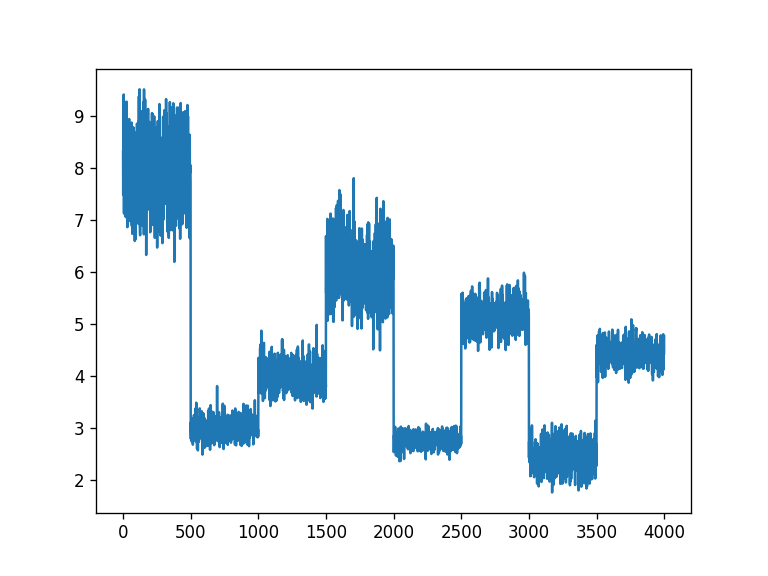

In [103]:
plt.plot(pw_dist_matrix[0,1]);

### Local linear embedding for reference points:

In [3]:
embedding = LocallyLinearEmbedding(n_components=2)
Y_embedded = embedding.fit_transform(Y)

In [5]:
ref_points = np.arange(50)
n_ref = len(ref_points)
Nobs = np.shape(Y)[0]
train = np.setdiff1d(np.arange(Nobs), ref_points)
y_ref = Y[ref_points]
X_ref = np.zeros((n_ref,2))
for i in range(n_ref) :
    X_ref[i] = Y_embedded[i]

In [7]:
Y_new = np.zeros(np.shape(Y))
for i in range(n_ref) :
    Y_new[i] = Y[ref_points[i]]
Y_new[n_ref::] = Y[np.setdiff1d(np.arange(Nobs), ref_points)]

In [8]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=2, 
                      out_dim=3, 
                      hidden_dim_1=50,
                      n_ref=n_ref,
                      y=Y_new[n_ref:], 
                      y_ref=Y_new[:n_ref],
                      X_ref=X_ref)

In [ ]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=4,chains=4,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints);

In [13]:
pw_dist_obs = np.genfromtxt('GeodesicDistance/pw_dist.txt', delimiter=',')